# Programa Monxo medi no continu

exact_soln  [ 2.66901857  7.55178196  9.34725317 13.9452195  16.96084541]

2025-04-22 12:12:04,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 6s, Remaining: 0s, Rate: 1.7e-01/s
evals^2
[  6.88754154+0.j  56.8120923 -0.j  86.39604236+0.j 187.99466827+0.j
 287.01942047+0.j]

evals.size (before)  130
evals.size (after removing inf)  126
evals.size (after removing < 0)  126

True evals   [ 2.66901857  7.55178196  9.34725317 13.9452195  16.96084541]
Eigenvalues  [ 2.62441261+0.j  7.53737967-0.j  9.29494714+0.j 13.71111477+0.j
 16.94164751+0.j]
Relative error  [0.0167125  0.00190714 0.00559587 0.01678745 0.0011319 ]

Eigenvalues whose eigenfunctions are plotted, real and imaginary parts
0113    +6.89e+00    +0.00e+00
0124    +5.68e+01    -0.00e+00
0115    +8.64e+01    +0.00e+00
0126    +1.88e+02    +0.00e+00
0116    +2.87e+02    +0.00e+00
0125    +3.58e+02    +0.00e+00
Eigenvalues whose eigenfunctions are plotted, real and imaginary parts
0113    +6.89e+00    +0

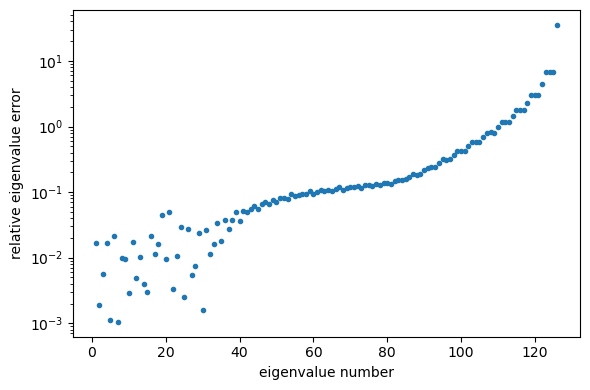

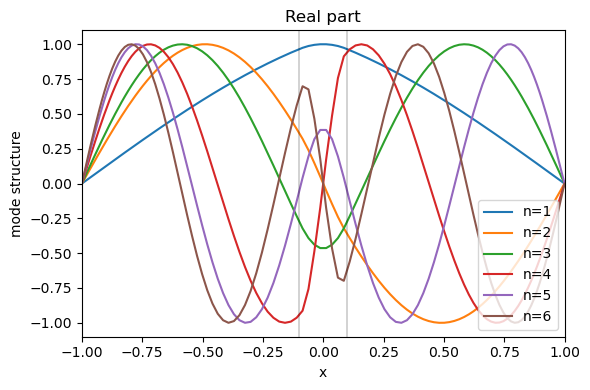

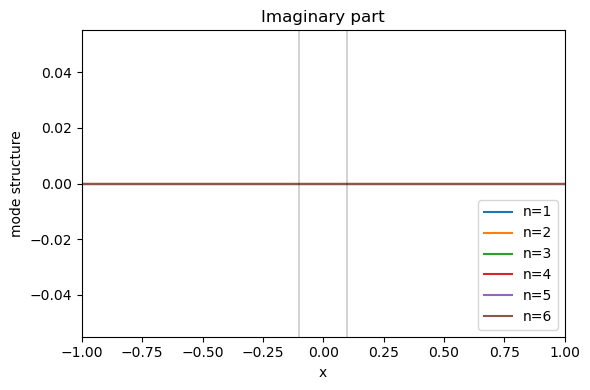

In [ ]:
"""
Dedalus script computing the eigenmodes of waves on a clamped string.
This script demonstrates solving a 1D eigenvalue problem and produces
plots of the first few eigenmodes and the relative error of the eigenvalues.
It should take just a few seconds to run (serial only).

We use a Legendre basis to solve the EVP:
    s*u + c**2 * dx(dx(u)) = 0
    u(x=-Lx) = 0
    u(x=Lx) = 0
where s is the eigenvalue.

For the second derivative on a closed interval, we need two tau terms.
Here we choose to use a first-order formulation, putting one tau term
on an auxiliary first-order variable and another in the PDE, and lifting
both to the first derivative basis.

To run and plot:
    $ python3 waves_on_a_string.py
"""

import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# def dispersion_relation_even(omega):
#     disprel = ci_by_ce * np.cos(omega * (Lx - x0) / ce) * np.cos(omega * x0 / ci) - \
#         np.sin(omega * (Lx - x0) / ce) * np.sin(omega * x0 / ci)
#     return disprel
# def dispersion_relation_odd(omega):
#     disprel = ci_by_ce * np.cos(omega * (Lx - x0) / ce) * np.sin(omega * x0 / ci) + \
#         np.sin(omega * (Lx - x0) / ce) * np.cos(omega * x0 / ci)
#     return disprel

def dispersion_relation(omega):
    disprel_even = ci_by_ce * np.cos(omega * (Lx - x0) / ce) * np.cos(omega * x0 / ci) - \
        np.sin(omega * (Lx - x0) / ce) * np.sin(omega * x0 / ci)
    disprel_odd = ci_by_ce * np.cos(omega * (Lx - x0) / ce) * np.sin(omega * x0 / ci) + \
        np.sin(omega * (Lx - x0) / ce) * np.cos(omega * x0 / ci)
    disprel = disprel_even * disprel_odd
    return disprel

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln

# Parameters
Lx = 1
x0 = Lx / 10
Nx = 128
dtype = np.complex128

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(-Lx, Lx))

# Fields
u = dist.Field(name='u', bases=xbasis)
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
s = dist.Field(name='s')

# Propagation speed squared.
c2 = dist.Field(name='cs2', bases=xbasis)
ci = 1.0
ce = np.sqrt(6.0)
ci2 = ci * ci
ce2 = ce * ce
ci_by_ce = ci / ce
x = dist.local_grid(xbasis)
c2['g'] = np.piecewise(x, [x < -x0, (-x0 <= x) * (x <= x0), x > x0], [ce2, ci2, ce2])
# c2['g'] = 1

# Get the first (i.e. positive) Nevals eigenvalues.
Nevals = np.rint(Nx*1.2).astype(int)
exact_soln = get_eigenvalues(Nevals)

# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction
uxx = dx(ux) + lift(tau_2)

# Problem
problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
problem.add_equation("s*u + c2 * uxx = 0")
problem.add_equation("u(x=-Lx) = 0")
problem.add_equation("u(x=Lx) = 0")

# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)
print('evals^2')
print(evals[0:5])
print()
print('evals.size (before) ', evals.size)
evals = evals[~np.isinf(evals)]
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0]
print('evals.size (after removing < 0) ', evals.size)
print()
evals = np.sqrt(evals)
n = 1 + np.arange(evals.size)
# true_evals = (n * np.pi / (2*Lx))**2
true_evals = exact_soln[0:evals.size]
relative_error = np.abs(evals - true_evals) / true_evals
print("True evals  ", true_evals[0:5])
print("Eigenvalues ", evals[0:5])
print("Relative error ", relative_error[0:5])
print()

# Plot
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("eigenvalue number")
plt.ylabel("relative eigenvalue error")
plt.tight_layout()
# plt.savefig("eigenvalue_error.pdf")
# plt.savefig("eigenvalue_error.png", dpi=200)

# Plot real part of eigenfunctions
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
print("Eigenvalues whose real eigenfunctions are plotted, real and imaginary parts")
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:6], start=1):
    solver.set_state(idx, solver.subsystems[0])
    if solver.eigenvalues[idx].real > 0:
        print(f"{idx:04d}    {solver.eigenvalues[idx].real:+.2e}    {solver.eigenvalues[idx].imag:+.2e}")
        ug = (u['g'] / u['g'][1]).real
#        plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
        plt.plot(x, (u['g'] / u['g'][1]).real/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(-Lx, Lx)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.axvline(-x0, color='k', linewidth=0.25)
plt.axvline(x0, color='k', linewidth=0.25)
plt.title("Real part")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
#plt.savefig("real.png", dpi=200)


### Ell fa es plot en funció si sa part real de s'autovalor és positiva...

# Plot imaginary part of eigenfunctions
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
print("Eigenvalues whose imaginary eigenfunctions are plotted, real and imaginary parts")
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:6], start=1):
    solver.set_state(idx, solver.subsystems[0])
    if solver.eigenvalues[idx].real > 0:
        print(f"{idx:04d}    {solver.eigenvalues[idx].real:+.2e}    {solver.eigenvalues[idx].imag:+.2e}")
        ug = (u['g'] / u['g'][1]).real
        ui = (u['g'] / u['g'][1]).imag
#        plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
        plt.plot(x, (u['g'] / u['g'][1]).imag/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(-Lx, Lx)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.axvline(-x0, color='k', linewidth=0.25)
plt.axvline(x0, color='k', linewidth=0.25)
plt.title("Imaginary part")
plt.tight_layout()
# plt.savefig("eigenvectors.pdf")
# plt.savefig("imag.png", dpi=200)
